In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color='yellow',
                          fill=True, alpha=0.2)
    
    outer_box_lines = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color='black',
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)


    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, outer_box_lines, top_free_throw,
                      bottom_free_throw,restricted, corner_three_a,
                      corner_three_b, three_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        outer_col = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color='yellow', fill=True, alpha = 0.2)
        
        court_elements.append(outer_col)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


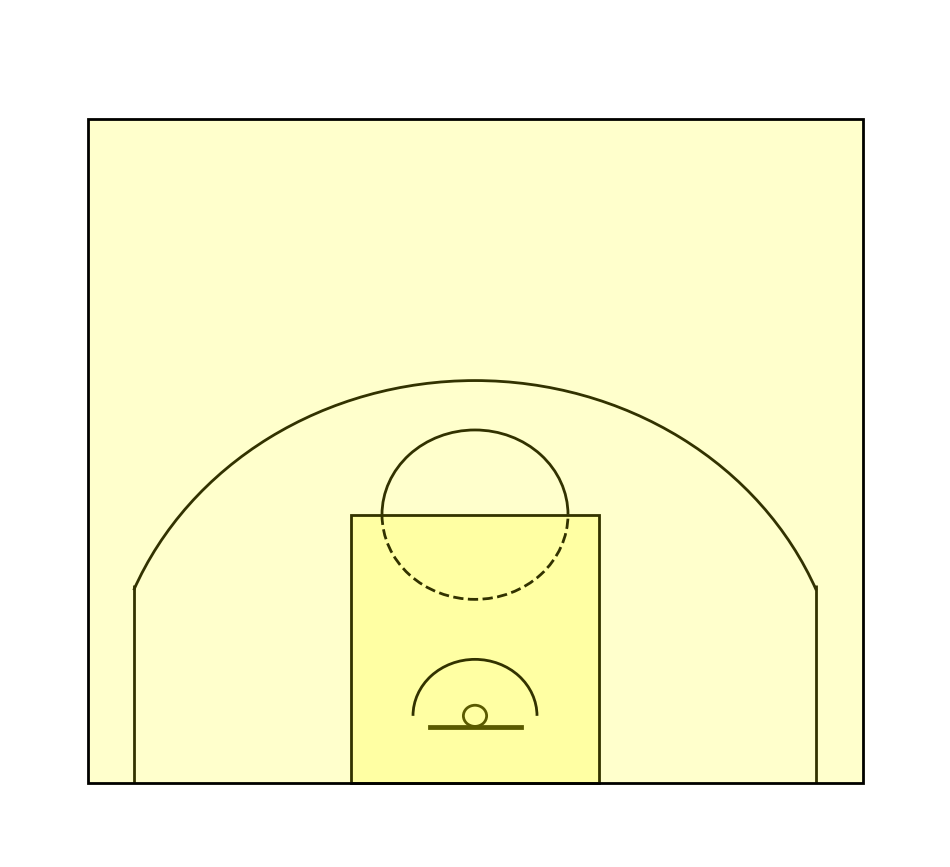

In [35]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()

In [56]:
# Read in the data
df = pd.read_pickle("LeBronShots.pickle")

Aggiunta dei tiri di Lebron nel periodo compreso tra la stagione 2003-04 e la stagione 2009-10 (inclusa)

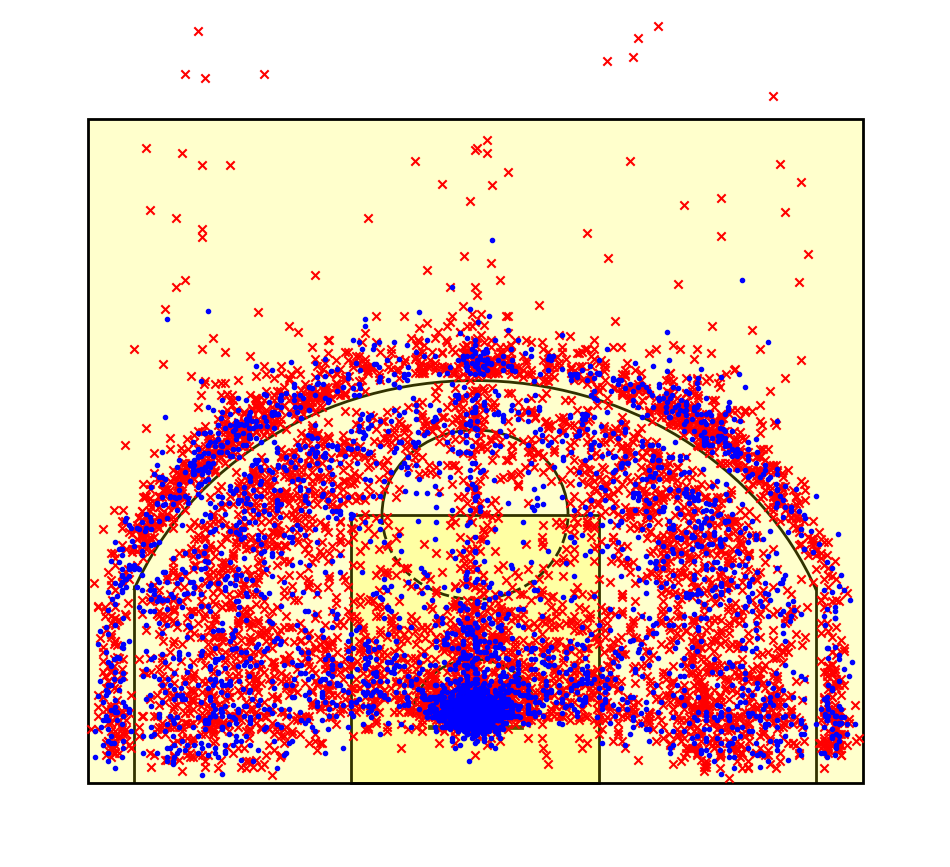

In [59]:
# missed shot = x
# made shot = o
#shots since 2003-04 to 2009-10
Seasons = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10']

made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons))]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons))]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue", label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()



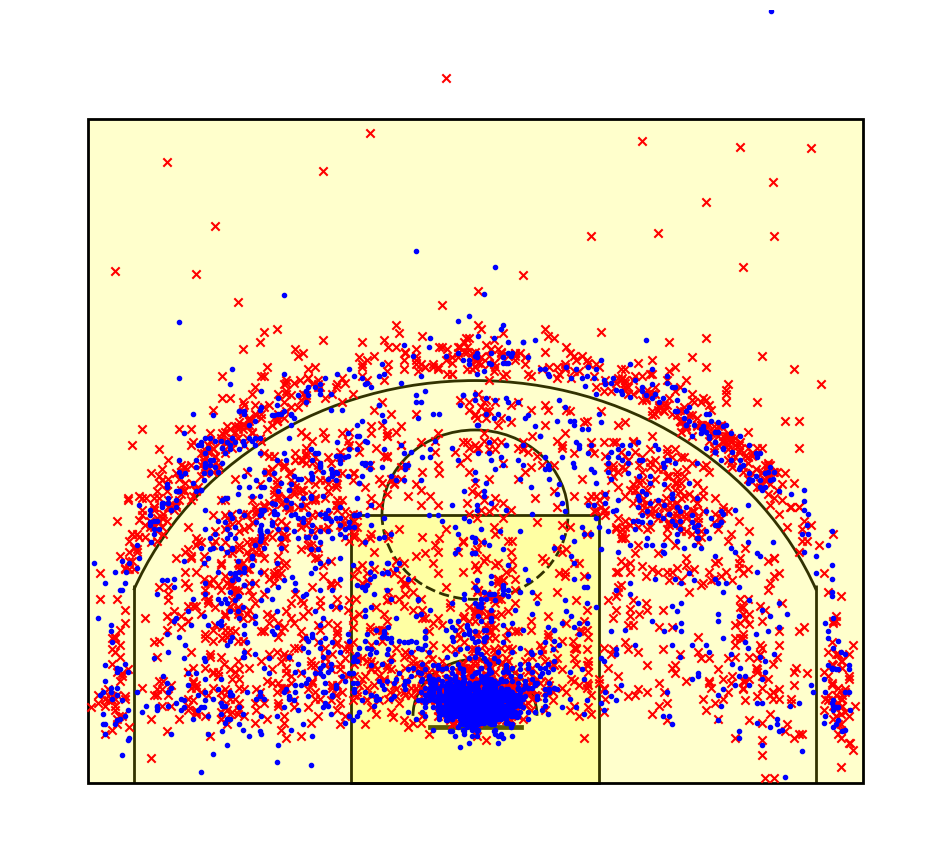

In [60]:
Seasons2 = ['2010-11', '2011-12', '2012-13', '2013-14']

made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons2))]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons2))]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue", label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()


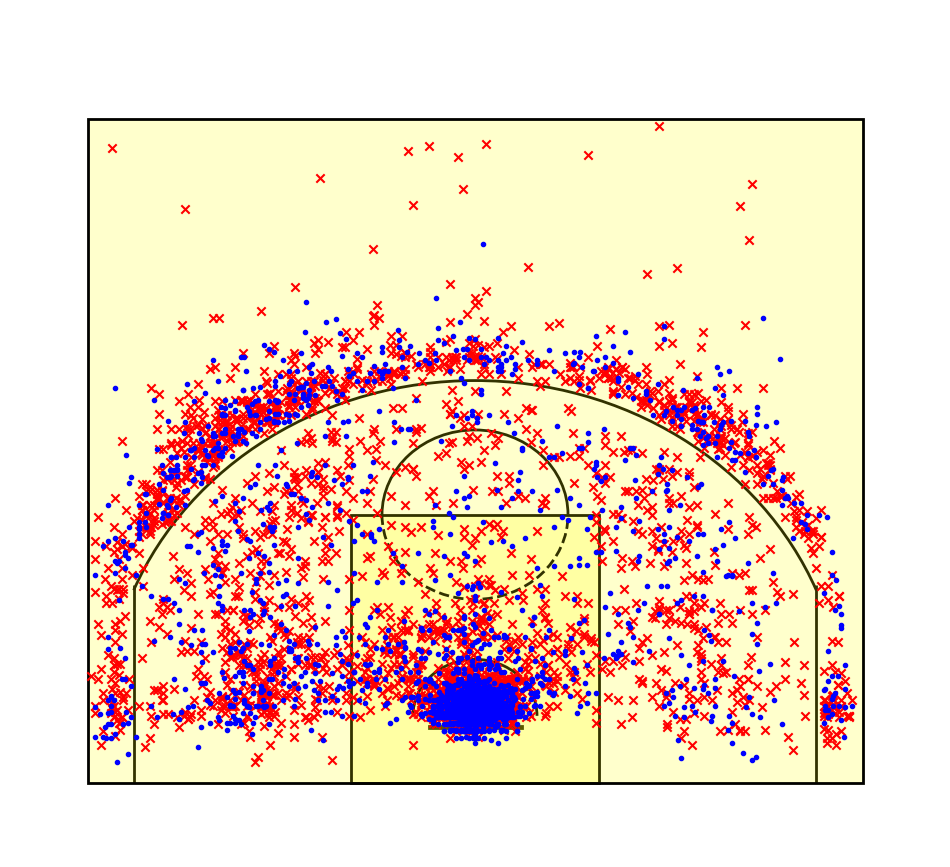

In [61]:
Seasons3 = ['2014-15', '2015-16', '2016-17', '2017-18']


made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons3))]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons3))]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue", label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()

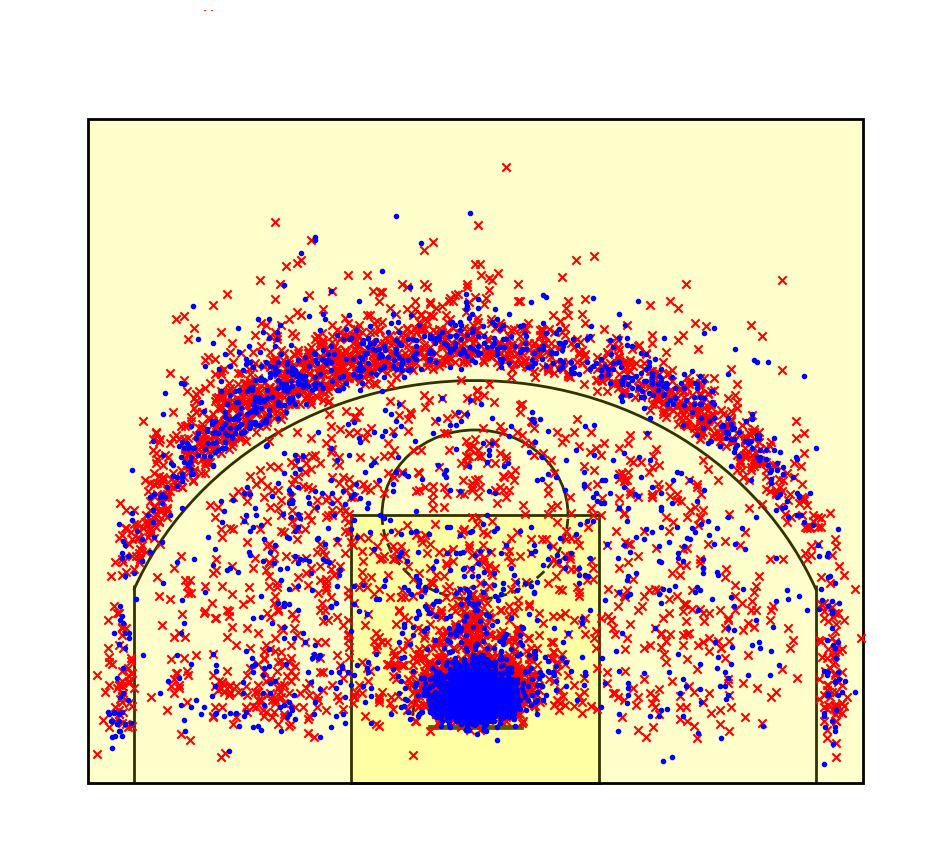

In [62]:
Seasons4 = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'] 


made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons4))]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons4))]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue", label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()